In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Pack the input data into data generators with applied data augmentation

In [ ]:
# Taken from this kernel: https://www.kaggle.com/vipoooool/plant-diseases-classification-using-alexnet
# Docs: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

# Define a data generator with data augmentation transformations for the
# training dataset.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"

train_set = train_datagen.flow_from_directory(base_dir + '/train',
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='categorical')

valid_set = valid_datagen.flow_from_directory(base_dir + '/valid',
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


# Transfer learning with VGG-16 pretrained on the ImageNet

## Define the model

In [ ]:
base_model = keras.applications.VGG16(
    weights="imagenet",  # load weights pretrained on the ImageNet
    input_shape=(224, 224, 3),
    include_top=False  # do not include the ImageNet classifier at the top
)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(38)(x)

vgg16_model = keras.Model(inputs, outputs, name='pretrained_vgg16')
vgg16_model.summary()

Model: "pretrained_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 38)                19494     
Total params: 14,734,182
Trainable params: 19,494
Non-trainable params: 14,714,688
_________________________________________________________________


## Compile and train the model

In [ ]:
vgg16_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()]
)

epochs = 10

# train_num = train_set.samples  # num of training samples
# valid_num = valid_set.samples  # num of validation samples

vgg16_history = vgg16_model.fit(train_set,
                                steps_per_epoch=150,  # use 150 random batches (= 4800 samples) for training
                                validation_data=valid_set,
                                epochs=epochs,
                                validation_steps=100,  # use 100 random batches (= 3200 samples) for validation
)

Epoch 1/10
150/150 [==============================] - 101s 670ms/step - loss: 3.4852 - categorical_accuracy: 0.1088 - val_loss: 3.1228 - val_categorical_accuracy: 0.2484
Epoch 2/10
150/150 [==============================] - 97s 648ms/step - loss: 3.0133 - categorical_accuracy: 0.2881 - val_loss: 2.7238 - val_categorical_accuracy: 0.4794
Epoch 3/10
150/150 [==============================] - 96s 639ms/step - loss: 2.6671 - categorical_accuracy: 0.4238 - val_loss: 2.3837 - val_categorical_accuracy: 0.5666
Epoch 4/10
150/150 [==============================] - 94s 624ms/step - loss: 2.4148 - categorical_accuracy: 0.5085 - val_loss: 2.1612 - val_categorical_accuracy: 0.6534
Epoch 5/10
150/150 [==============================] - 93s 617ms/step - loss: 2.2208 - categorical_accuracy: 0.5419 - val_loss: 1.9726 - val_categorical_accuracy: 0.6800
Epoch 6/10
150/150 [==============================] - 92s 613ms/step - loss: 2.0550 - categorical_accuracy: 0.5944 - val_loss: 1.8254 - val_categorical_ac

## Evaluate the model on the validation data

In [ ]:
results = vgg16_model.evaluate(valid_set)
print('val loss:', results[0])
print('val acc:', results[1])

550/550 [==============================] - 84s 153ms/step - loss: 1.4149 - categorical_accuracy: 0.7271
val loss: 1.41493558883667
val acc: 0.7270658016204834


## Plot the training progress

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set parameters for plotting
plt.rc('figure', figsize=(8, 4))
sns.set(font_scale=1)

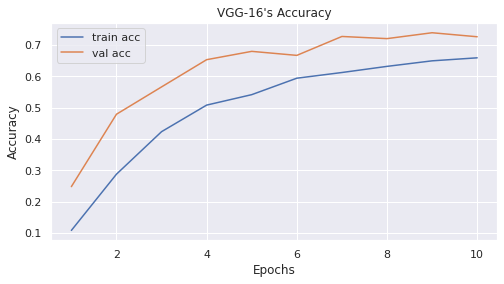

In [ ]:
train_acc = vgg16_history.history['categorical_accuracy']
val_acc = vgg16_history.history['val_categorical_accuracy']

epochs_list = list(range(1, epochs + 1))

plt.plot(epochs_list, train_acc, label='train acc')
plt.plot(epochs_list, val_acc, label='val acc')
plt.title("VGG-16's Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

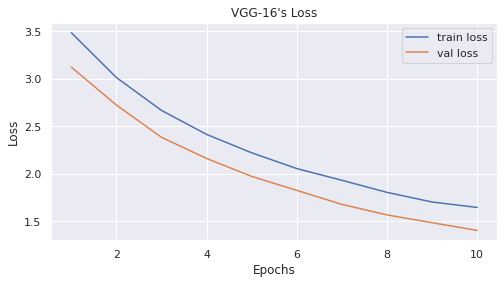

In [ ]:
train_loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']

plt.plot(epochs_list, train_loss, label='train loss')
plt.plot(epochs_list, val_loss, label='val loss')
plt.title("VGG-16's Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

## Save the model

In [ ]:
vgg16_model.save('vgg16')

# Transfer learning with MobileNet pretrained on the ImageNet

## Define the model

In [ ]:
base_model = keras.applications.MobileNet(
    weights="imagenet",  # load weights pretrained on the ImageNet
    input_shape=(224, 224, 3),
    include_top=False  # do not include the ImageNet classifier at the top
)

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(38)(x)

mobilenet_model = keras.Model(inputs, outputs, name='pretrained_mobilenet')
mobilenet_model.summary()

Model: "pretrained_mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                38950     
Total params: 3,267,814
Trainable params: 38,950
Non-trainable params: 3,228,864
_________________________________________________________________


## Compile and train the model

In [ ]:
mobilenet_model.compile(optimizer=keras.optimizers.Adam(),
                        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                        metrics=[keras.metrics.CategoricalAccuracy()]
)

epochs = 10

mobilenet_history = mobilenet_model.fit(train_set,
                                        steps_per_epoch=150,  # use 150 random batches (= 4800 samples) for training
                                        validation_data=valid_set,
                                        epochs=epochs,
                                        validation_steps=100,  # use 100 random batches (= 3200 samples) for validation
)

Epoch 1/10
150/150 [==============================] - 85s 569ms/step - loss: 1.9890 - categorical_accuracy: 0.4819 - val_loss: 0.7935 - val_categorical_accuracy: 0.8181
Epoch 2/10
150/150 [==============================] - 84s 562ms/step - loss: 0.7562 - categorical_accuracy: 0.7923 - val_loss: 0.5187 - val_categorical_accuracy: 0.8587
Epoch 3/10
150/150 [==============================] - 84s 563ms/step - loss: 0.5293 - categorical_accuracy: 0.8512 - val_loss: 0.3484 - val_categorical_accuracy: 0.9087
Epoch 4/10
150/150 [==============================] - 85s 564ms/step - loss: 0.4215 - categorical_accuracy: 0.8775 - val_loss: 0.3135 - val_categorical_accuracy: 0.9069
Epoch 5/10
150/150 [==============================] - 84s 559ms/step - loss: 0.4146 - categorical_accuracy: 0.8771 - val_loss: 0.3351 - val_categorical_accuracy: 0.9006
Epoch 6/10
150/150 [==============================] - 82s 549ms/step - loss: 0.3596 - categorical_accuracy: 0.8913 - val_loss: 0.2766 - val_categorical_acc

## Evaluate the model on the validation data

In [ ]:
results = mobilenet_model.evaluate(valid_set)
print('val loss:', results[0])
print('val acc:', results[1])

550/550 [==============================] - 74s 134ms/step - loss: 0.2133 - categorical_accuracy: 0.9323
val loss: 0.2132890224456787
val acc: 0.9322786331176758


## Plot the training progress

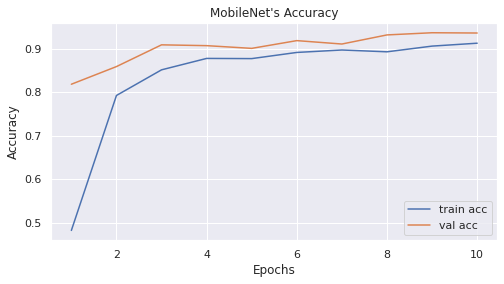

In [ ]:
train_acc = mobilenet_history.history['categorical_accuracy']
val_acc = mobilenet_history.history['val_categorical_accuracy']

epochs_list = list(range(1, epochs + 1))

plt.plot(epochs_list, train_acc, label='train acc')
plt.plot(epochs_list, val_acc, label='val acc')
plt.title("MobileNet's Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

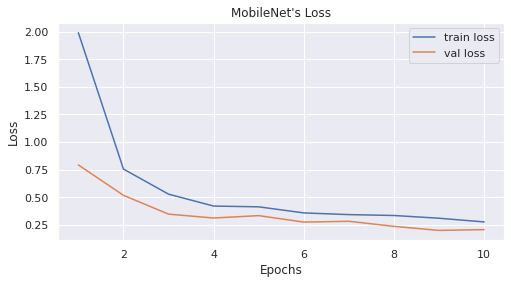

In [ ]:
train_loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']

plt.plot(epochs_list, train_loss, label='train loss')
plt.plot(epochs_list, val_loss, label='val loss')
plt.title("MobileNet's Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

## Save the model

In [ ]:
mobilenet_model.save('mobilenet')

## Unfreeze the base model and apply fine-tuning of the weights

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
mobilenet_model.summary()

Model: "pretrained_mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                38950     
Total params: 3,267,814
Trainable params: 3,245,926
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
mobilenet_model.compile(optimizer=keras.optimizers.Adam(1e-5),  # set a small learning rate
                        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                        metrics=[keras.metrics.CategoricalAccuracy()]
)

epochs = 5

mobilenet_ft_history = mobilenet_model.fit(train_set,
                                           steps_per_epoch=150,   # use 150 random batches (= 4800 samples) for training
                                           validation_data=valid_set,
                                           epochs=epochs,
                                           validation_steps=100  # use 100 random batches (= 3200 samples) for validation
)

Epoch 1/5
150/150 [==============================] - 93s 620ms/step - loss: 0.2707 - categorical_accuracy: 0.9160 - val_loss: 0.1650 - val_categorical_accuracy: 0.9497
Epoch 2/5
150/150 [==============================] - 90s 599ms/step - loss: 0.2224 - categorical_accuracy: 0.9262 - val_loss: 0.1652 - val_categorical_accuracy: 0.9447
Epoch 3/5
150/150 [==============================] - 91s 606ms/step - loss: 0.2067 - categorical_accuracy: 0.9327 - val_loss: 0.1663 - val_categorical_accuracy: 0.9459
Epoch 4/5
150/150 [==============================] - 89s 592ms/step - loss: 0.2081 - categorical_accuracy: 0.9308 - val_loss: 0.1565 - val_categorical_accuracy: 0.9491
Epoch 5/5
150/150 [==============================] - 89s 594ms/step - loss: 0.1768 - categorical_accuracy: 0.9410 - val_loss: 0.1298 - val_categorical_accuracy: 0.9556


## Evaluate the fine-tuned model

In [ ]:
results = mobilenet_model.evaluate(valid_set)
print('val loss:', results[0])
print('val acc:', results[1])

550/550 [==============================] - 74s 135ms/step - loss: 0.1274 - categorical_accuracy: 0.9586
val loss: 0.12739785015583038
val acc: 0.9585704803466797


## Plot the training progress of the fine-tuned model

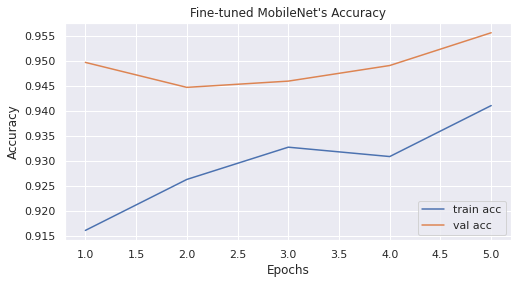

In [ ]:
train_acc = mobilenet_ft_history.history['categorical_accuracy']
val_acc = mobilenet_ft_history.history['val_categorical_accuracy']

epochs_list = list(range(1, epochs + 1))

plt.plot(epochs_list, train_acc, label='train acc')
plt.plot(epochs_list, val_acc, label='val acc')
plt.title("Fine-tuned MobileNet's Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

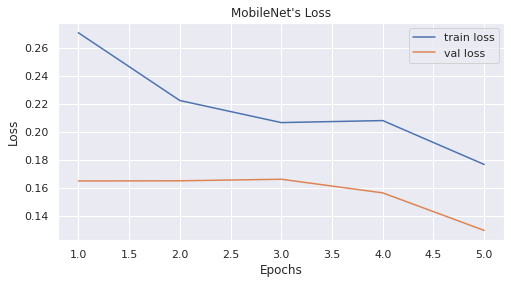

In [ ]:
train_loss = mobilenet_ft_history.history['loss']
val_loss = mobilenet_ft_history.history['val_loss']

plt.plot(epochs_list, train_loss, label='train loss')
plt.plot(epochs_list, val_loss, label='val loss')
plt.title("MobileNet's Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

## Save the fine-tuned model

In [ ]:
mobilenet_model.save('mobilenet-fine-tuned')